# 1.0 End-to-End Project

## 1.1 Import Libraries

In [ ]:
# importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import pickle
import joblib

## 1.2 Get Data

In [ ]:
!gunzip 'listings.csv.gz'

In [ ]:
# Brought along the changes we made to the 'rio_listings' Dataframe.
target_columns = ["accommodates", "bathrooms","bedrooms","beds","minimum_nights",
                  "maximum_nights","number_of_reviews","price"]
          
rio_listings = pd.read_csv("listings.csv",usecols=target_columns)

## 1.3 Clean, Prepare & Manipulate Data

In [ ]:
# Exploratory Data Analyzis (EDA)
rio_listings.sample(5)

In [ ]:
# Check missing values
rio_listings.info()

In [ ]:
# Data preparation
stripped_commas = rio_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
rio_listings['price'] = stripped_dollars.astype('float')

# clean missing values
rio_listings.dropna(axis=0,inplace=True)

In [ ]:
# Check missing values
rio_listings.info()

In [ ]:
# copy the dataset
rio_iqr = rio_listings[target_columns].copy()

# 25th Quartile
Q1 = rio_iqr.quantile(0.25)

# 75th Quartile
Q3 = rio_iqr.quantile(0.75)

# Inter-quartile range
IQR = Q3 - Q1

# lower limit
low = Q1 - 1.5 * IQR

# upper limit
up = Q3 + 1.5 * IQR

# remove outliers
rio_iqr = rio_iqr[((rio_iqr > low).all(axis=1) & (rio_iqr < up).all(axis=1))]

In [ ]:
print(f"Before: {rio_listings.shape[0]} rows\nAfter: {rio_iqr.shape[0]} rows")
print("Reduction of {:.2f} %".format((1-rio_iqr.shape[0]/rio_listings.shape[0])*100))

In [ ]:
# Identify feature with a high correlation to target
rio_iqr.corr()["price"].sort_values()

In [ ]:
sns.heatmap(rio_iqr.corr())

## 1.4 Train Model & Test Data (create a baseline model)

In [34]:
# Separate Data into a Training and Validation Datasets
test_size = 0.20
seed = 10

x_train, x_test, y_train, y_test = train_test_split(rio_iqr.drop(axis=1,labels=["price"]), 
                                                    rio_iqr["price"],
                                                    test_size=test_size, 
                                                    random_state=seed)

print(f"Train x: {x_train.shape}\nTrain y: {y_train.shape}")
print(f"Test x: {x_test.shape}\nTest y: {y_test.shape}")

Train x: (17809, 7)
Train y: (17809,)
Test x: (4453, 7)
Test y: (4453,)


In [35]:
# Train a baseline

# instantiate a knn object
knn = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)

# train the model
%time knn.fit(x_train,y_train)

CPU times: user 122 ms, sys: 626 µs, total: 122 ms
Wall time: 139 ms


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                    weights='uniform')

In [36]:
# predict
%time predict = knn.predict(x_test)

CPU times: user 265 ms, sys: 3.52 ms, total: 269 ms
Wall time: 211 ms


In [37]:
# evaluate
rmse = np.sqrt(mean_squared_error(y_test,predict))
print(rmse)

257.4683188776641


In [38]:
# Create a PIPELINE to investigate different Normalization techniques!!!

# Standardize the dataset
pipelines_list = []
pipelines_list.append(('NonScaledKnn', 
                  Pipeline([('KNN',
                             KNeighborsRegressor(n_neighbors=5,n_jobs=-1))])))
pipelines_list.append(('ScaledKnn', 
                  Pipeline([('Scaler', 
                             StandardScaler()),
                            ('KNN',
                             KNeighborsRegressor(n_neighbors=5, n_jobs=-1))])))

pipelines_list.append(('NormalizedKnn', 
                  Pipeline([('Normalizer', 
                             Normalizer()),
                            ('KNN',
                             KNeighborsRegressor(n_neighbors=5, n_jobs=-1))])))

pipelines_list.append(('RobustedKnn', 
                  Pipeline([('Robust', 
                             RobustScaler()),
                            ('KNN',
                             KNeighborsRegressor(n_neighbors=5, n_jobs=-1))])))

pipelines_list.append(('QuantiledKnn', 
                  Pipeline([('Quantile', 
                             QuantileTransformer()),
                            ('KNN',
                             KNeighborsRegressor(n_neighbors=5, n_jobs=-1))])))

pipelines_list.append(('PoweredKnn', 
                  Pipeline([('Power', 
                             PowerTransformer()),
                            ('KNN',
                             KNeighborsRegressor(n_neighbors=5, n_jobs=-1))])))


<img width="600" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1K6Gjqlrxte7qN1KPnlTNUKLGLxM-O0ZH">

In [39]:
# Using K-Fold Cross-Validation

# Cross-validation allows us to compare different 
# machine learning methods and get a sense of how
# well they will work in practice

# Test options and evaluation metric
num_folds = 10
scoring = 'neg_mean_squared_error'

In [43]:
pipelines_list[2][1]

Pipeline(memory=None,
         steps=[('Normalizer', Normalizer(copy=True, norm='l2')),
                ('KNN',
                 KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                     metric='minkowski', metric_params=None,
                                     n_jobs=-1, n_neighbors=5, p=2,
                                     weights='uniform'))],
         verbose=False)

In [44]:
results = []
names = []

for name, model in pipelines_list:
  # k-fold size
  kfold = KFold(n_splits=num_folds)
  # cross validation
  cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
  # store results
  results.append(-cv_results)
  names.append(name)
  print("%s Mean: %f Std: %f" % (name, 
                                      np.sqrt(-cv_results.mean()), 
                                      np.sqrt(cv_results.std())))

NonScaledKnn Mean: 258.165342 Std: 58.187715
ScaledKnn Mean: 259.392466 Std: 63.027124
NormalizedKnn Mean: 268.471385 Std: 53.202188
RobustedKnn Mean: 257.081439 Std: 56.819537
QuantiledKnn Mean: 256.213915 Std: 56.446269
PoweredKnn Mean: 255.446941 Std: 59.693227


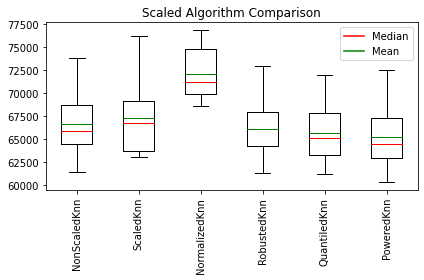

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(results,showmeans=True,meanline=True,
            medianprops = dict(linestyle='-', linewidth=1.0, color='red'),
            meanprops = dict(linestyle='-', linewidth=1.0, color='green')
            )
ax.set_xticklabels(names,rotation=90)
plt.title('Scaled Algorithm Comparison')
plt.tight_layout()

plt.plot([],label="Median",color="red")
plt.plot([],label="Mean",color="green")
plt.legend()
plt.show()

## 1.5 Improve the model

In [49]:
# KNN Algorithm tuning (beat the baseline)

# hyperparameter
k_values = np.array([1,5,10,15,20,25])
weights = ["uniform","distance"]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
metric = [1,2]

# number of combinations
models = (len(k_values) * len(weights) * len(algorithm) * len(metric))
rounds = models * num_folds

print(f"Number of models: {models}")
print(f"Complexity of evalution: {rounds} rounds")

param_grid = dict(n_neighbors=k_values, 
                  weights=weights,
                  algorithm=algorithm,
                  p=metric)

# Instantiate a normalization algorithm
pt = PowerTransformer()
# Learning the stats from feature
pt.fit(x_train)
# Transform x train
scaler = pt.transform(x_train)

# instantiate a model
model = KNeighborsRegressor()

# Test options and evaluation metric
num_folds = 10
scoring = 'neg_mean_squared_error'

# Grid Searcing with cross-validation
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    scoring=scoring,
                    cv=kfold)

Number of models: 96
Complexity of evalution: 960 rounds


In [ ]:
# train the model
grid_result = grid.fit(scaler, y_train)

# Print results
print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), 
                             grid_result.best_params_))

means = np.sqrt(-grid_result.cv_results_['mean_test_score'])
stds = np.sqrt(grid_result.cv_results_['std_test_score'])
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
result = pd.DataFrame(grid_result.cv_results_)
result.head()

In [52]:
result.shape

(96, 22)

In [ ]:
result.sort_values(by="rank_test_score")

## 1.6 Finalize Model

In [55]:
# predict using the best estimator
# pay attention in normalizer instance that was the same used in the train
predict = grid_result.best_estimator_.predict(pt.transform(x_test))
rmse = np.sqrt(mean_squared_error(y_test,predict))
print(rmse)

239.57390023355893


In [56]:
# Save the model using pickle
with open('pipe.pkl', 'wb') as file:
  pickle.dump(grid_result, file)

In [57]:
# Save the model using joblib
with open('pipe.joblib', 'wb') as file:
  joblib.dump(grid_result, file)

In [58]:
# Under the production environment [pickle]
with open('pipe.pkl', 'rb') as file:
  model = pickle.load(file)

predict = model.best_estimator_.predict(pt.transform(x_test))
rmse = np.sqrt(mean_squared_error(predict,y_test))
print(rmse)  

239.57390023355893


In [59]:
# Under the production environment [joblib]
with open('pipe.joblib', 'rb') as file:
  model = joblib.load(file)

predict = model.best_estimator_.predict(pt.transform(x_test))
rmse = np.sqrt(mean_squared_error(predict,y_test))
print(rmse)

239.57390023355893


# 2.0 References

1. https://machinelearningmastery.com/k-fold-cross-validation/
2. https://scikit-learn.org/stable/modules/cross_validation.html
3. https://en.wikipedia.org/wiki/Cross-validation_(statistics)
4. https://scikit-learn.org/stable/modules/model_persistence.html